# Anime Recommender

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from surprise import AlgoBase, trainset, Dataset, Reader, accuracy, dump, KNNBaseline, BaselineOnly
from surprise.prediction_algorithms.predictions import PredictionImpossible
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.utils import get_rng
from operator import itemgetter
import pickle
import os

# Model Paths

In [3]:
sgd_model_path = './models/sgd_model.pkl'
knn_model_path = './models/knn_model.pkl'
knn_base_model_path = './models/knn_base_model.pkl'
als_model_path = './models/als_model.pkl'

# Data preprocessing for CF models

In [4]:
anime = pd.read_csv('./anime-data/anime.csv')
ratings = pd.read_csv('./anime-data/rating.csv')

In [5]:
ratings = ratings[ratings['rating'] != -1]
anime = anime.dropna()

In [6]:
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [7]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
anime = anime.sort_values('anime_id').reset_index(drop=True)

# Exploratory data analysis

In [9]:
num_ratings = len(ratings)
num_anime = ratings['anime_id'].nunique()
num_users = ratings['user_id'].nunique()
print(f"Number of Ratings: {num_ratings}")
print(f"Number of Anime: {num_anime}")
print(f"Number of Users: {num_users}")

Number of Ratings: 6337241
Number of Anime: 9927
Number of Users: 69600


In [10]:
ratings_stats = ratings.groupby('anime_id')['rating'].agg(['count', 'mean']).reset_index()
anime_stats = anime.merge(ratings_stats, on='anime_id')
anime_stats.head()

,anime_id,name,genre,type,episodes,rating,members,count,mean
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,13449,8.869433
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636,5790,8.439724
2,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069,9385,8.419393
3,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905,2169,7.533426
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848,308,7.198052


In [11]:
v = anime_stats['count']
R = anime_stats['mean']
C = anime_stats['mean'].mean()
# Only consider anime which have 70 percentile or above vote counts
m = anime_stats['count'].quantile(0.70)

In [12]:
anime_stats['weighted_average'] = ((R*v)+(C*m))/(v+m)

In [13]:
anime_stats.head()

,anime_id,name,genre,type,episodes,rating,members,count,mean,weighted_average
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,13449,8.869433,8.827892
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636,5790,8.439724,8.363755
2,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069,9385,8.419393,8.372292
3,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905,2169,7.533426,7.439696
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848,308,7.198052,6.947276


### Avg ratings distribution

In [14]:
tmp = anime_stats[['anime_id', 'weighted_average']].reset_index(drop=True)
tmp.head()

,anime_id,weighted_average
0,1,8.827892
1,5,8.363755
2,6,8.372292
3,7,7.439696
4,8,6.947276


In [15]:
tmp['weighted_average'].describe()

count    9892.000000
mean        6.873027
std         0.449980
min         3.305675
25%         6.627486
50%         6.663813
75%         6.985079
max         9.291231
Name: weighted_average, dtype: float64

Text(0.5, 1.0, 'Avg rating for items distribution')

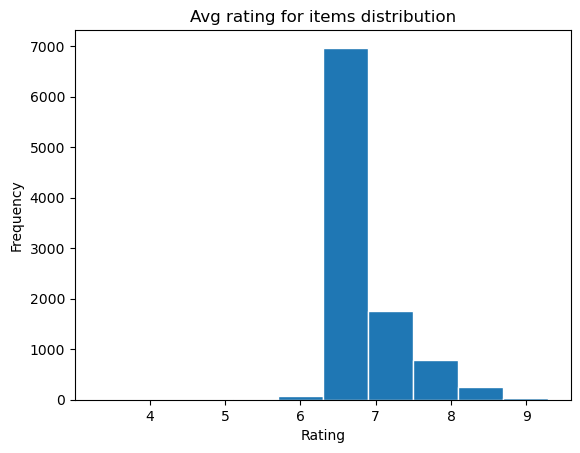

In [16]:
plt.hist(tmp['weighted_average'], bins=10, edgecolor='white')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title("Avg rating for items distribution")

### Item popularity curve

In [17]:
tmp2 = anime_stats[['anime_id', 'count']].reset_index(drop=True)
tmp2=tmp2.sort_values(by=['count'],ascending=False)
tmp2.insert(0, 'rank', range(1, 1 + len(tmp2)))
tmp2.drop('anime_id', axis=1, inplace=True)
tmp2.head()

,rank,count
1388,1,34226
6322,2,26310
7058,3,25290
1426,4,24126
4567,5,23565


In [18]:
tmp2['count'].describe()

count     9892.000000
mean       640.633441
std       1798.641286
min          1.000000
25%          9.000000
50%         57.000000
75%        398.250000
max      34226.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'Item popularity curve')

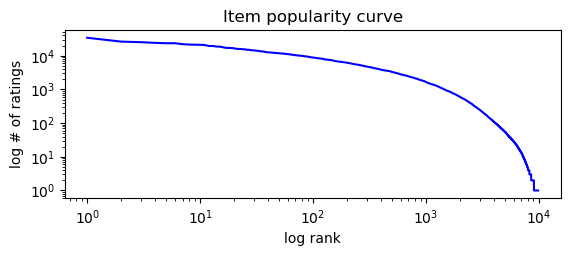

In [19]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(tmp2['rank'],tmp2['count'],color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('log rank')
plt.ylabel('log # of ratings')
plt.title("Item popularity curve")

### User rating frequency

In [20]:
tmp3 = ratings.groupby('user_id')['rating'].agg('count').reset_index()
tmp3.columns = ['user_id', 'count']
tmp3=tmp3.sort_values(by=['count'],ascending=False)
tmp3.insert(0, 'rank', range(1, 1 + len(tmp3)))
tmp3.drop('user_id', axis=1, inplace=True)
tmp3.head()

,rank,count
40277,1,3747
50822,2,2905
54550,3,2689
56512,4,2632
48906,5,2621


In [21]:
tmp3['count'].describe()

count    69600.000000
mean        91.052313
std        135.764253
min          1.000000
25%         13.000000
50%         45.000000
75%        114.000000
max       3747.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'User rating frequency curve')

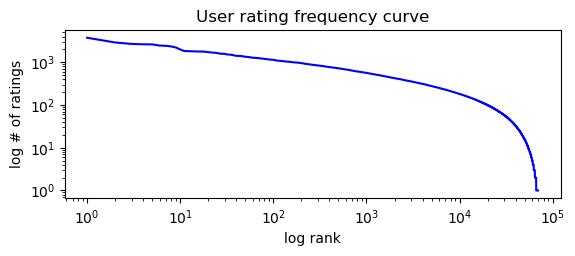

In [22]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(tmp3['rank'],tmp3['count'],color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('log rank')
plt.ylabel('log # of ratings')
plt.title("User rating frequency curve")

## Filter ratings based on analysis

In [23]:
filt_anime = ratings['anime_id'].value_counts() > 60
filt_anime = filt_anime[filt_anime].index.tolist()

filt_user = ratings['user_id'].value_counts() > 40
filt_user2 = ratings['user_id'].value_counts() < 250
filt_user = filt_user[filt_user == filt_user2].index.tolist()

filt_ratings = ratings[(ratings['anime_id'].isin(filt_anime)) & (ratings['user_id'].isin(filt_user))].reset_index(drop=True)

In [24]:
filt_ratings_stats = filt_ratings.groupby('anime_id')['rating'].agg(['count', 'mean']).reset_index()
filt_anime_stats = anime.merge(filt_ratings_stats, on='anime_id')
filt_anime_stats.head()

,anime_id,name,genre,type,episodes,rating,members,count,mean
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,8156,8.875061
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636,3463,8.459428
2,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069,5638,8.432778
3,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905,1134,7.593474
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848,129,7.232558


In [25]:
v = filt_anime_stats['count']
R = filt_anime_stats['mean']
C = filt_anime_stats['mean'].mean()
# Only consider anime which have 70 percentile or above vote counts
m = filt_anime_stats['count'].quantile(0.70)

In [26]:
filt_anime_stats['weighted_average'] = ((R*v)+(C*m))/(v+m)

### Avg ratings distribution

In [27]:
filt_tmp = filt_anime_stats[['anime_id', 'weighted_average']].reset_index(drop=True)

Text(0.5, 1.0, 'Avg rating for items distribution')

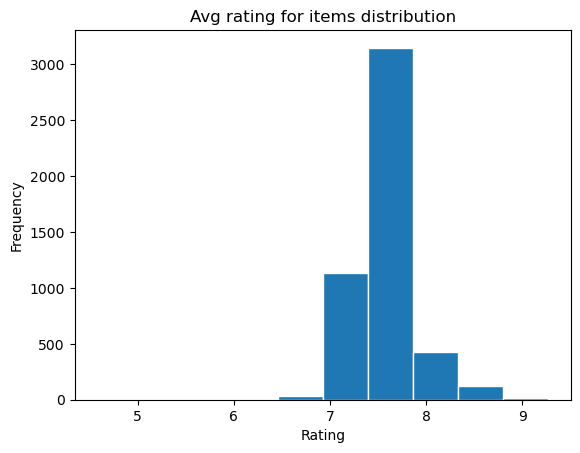

In [28]:
plt.hist(filt_tmp['weighted_average'], bins=10, edgecolor='white')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title("Avg rating for items distribution")

### Item popularity curve

In [29]:
filt_tmp2 = anime_stats[['anime_id', 'count']].reset_index(drop=True)
filt_tmp2=filt_tmp2.sort_values(by=['count'],ascending=False)
filt_tmp2.insert(0, 'rank', range(1, 1 + len(filt_tmp2)))
filt_tmp2.drop('anime_id', axis=1, inplace=True)

Text(0.5, 1.0, 'Item popularity curve')

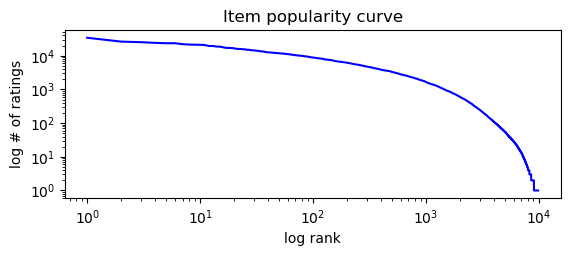

In [30]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(filt_tmp2['rank'],filt_tmp2['count'],color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('log rank')
plt.ylabel('log # of ratings')
plt.title("Item popularity curve")

### User rating frequency

In [31]:
filt_tmp3 = filt_ratings.groupby('user_id')['rating'].agg('count').reset_index()
filt_tmp3.columns = ['user_id', 'count']
filt_tmp3=filt_tmp3.sort_values(by=['count'],ascending=False)
filt_tmp3.insert(0, 'rank', range(1, 1 + len(filt_tmp3)))
filt_tmp3.drop('user_id', axis=1, inplace=True)
filt_tmp3.head()

,rank,count
26359,1,249
26092,2,249
8190,3,249
688,4,249
20122,5,249


In [32]:
filt_tmp3['count'].describe()

count    30393.000000
mean       106.587668
std         53.956151
min         10.000000
25%         62.000000
50%         92.000000
75%        142.000000
max        249.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'User rating frequency curve')

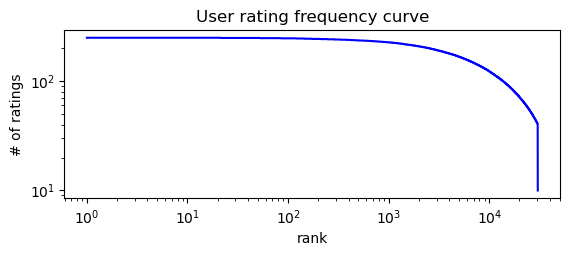

In [33]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(filt_tmp3['rank'],filt_tmp3['count'],color='blue')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('rank')
plt.ylabel('# of ratings')
plt.title("User rating frequency curve")

# Data preprocessing for content based model

In [34]:
anime_features = anime.drop(anime.loc[anime['genre'].isna()].index).reset_index(drop=True)
anime_features['genre'] = anime_features['genre'].apply(lambda x: x.split(","))

In [35]:
from collections import Counter

genres_counts = Counter(g for genres in anime_features['genre'] for g in genres)
genres = list(genres_counts.keys())
for g in genres:
    anime_features[g] = anime_features['genre'].transform(lambda x: int(g in x))

type_list = list(anime_features['type'].unique())
for t in type_list:
    anime_features[t] = anime_features['type'].transform(lambda x: int(t == x))

anime_features = anime_features.drop(['name', 'genre', 'type', 'episodes', 'rating', 'members'], axis=1)
anime_features = anime_features.set_index('anime_id')

In [36]:
anime_features.head()

,Action,Adventure,Comedy,Drama,Sci-Fi,Space,Mystery,Magic,Police,Supernatural,...,Seinen,Josei,Thriller,Police,Space,TV,Movie,OVA,Special,ONA
anime_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,1,0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


# SGD Model

In [37]:
class MF(AlgoBase):
    def __init__(self,learning_rate=0.005,num_epochs=10,num_factors=100, reg=0.02, verbose=False, biased=True):
        bsl_options = {
            "reg" : reg,
            "learning_rate": learning_rate,
            "n_epochs" : num_epochs,
        }
        self.biased = biased
        self.verbose = verbose
        self.num_factors = num_factors
        AlgoBase.__init__(self, bsl_options=bsl_options)

    def fit(self,train):
        AlgoBase.fit(self, train)
        self.sgd(train)


    def estimate(self,u,i):
        userKnown = self.trainset.knows_user(u)
        itemKnown = self.trainset.knows_item(i)
        if self.biased:
            est = self.trainset.global_mean

            if userKnown:
                est += self.bu[u]

            if itemKnown:
                est += self.bi[i]

            if userKnown and itemKnown:
                est += np.dot(self.qi[i], self.pu[u])
        else:
            if userKnown and itemKnown:
                est = np.dot(self.qi[i], self.pu[u])
            else:
                raise PredictionImpossible('User and item are unknown.')

        return est

    def sgd(self, train):
        lr, reg = self.bsl_options["learning_rate"], self.bsl_options["reg"]
        bu, bi = self.bu, self.bi
        n_epochs = self.bsl_options["n_epochs"]
        n_factors = self.num_factors
        biased = self.biased
        global_mean = self.trainset.global_mean

        rng = get_rng(None)

        bu = np.zeros(train.n_users, dtype=np.double)
        bi = np.zeros(train.n_items, dtype=np.double)
        P = rng.normal(loc=0, scale=1/n_factors, size=(train.n_users, n_factors))
        Q = rng.normal(loc=0, scale=1/n_factors, size=(train.n_items, n_factors))

        if not biased:
            global_mean = 0

        for i_epoch in range(n_epochs):
            if self.verbose:
                print("Processing epoch {}".format(i_epoch))

            for u, i, r in train.all_ratings():
                pred_r_ui = np.dot(P[u], Q[i])

                e_ui = r - (pred_r_ui + bu[u] + bi[i] + global_mean)

                if biased:
                    bu[u] += lr * (e_ui - reg * bu[u])
                    bi[i] += lr * (e_ui - reg * bi[i])

                P[u] += lr * (e_ui*Q[i] - reg*P[u])
                Q[i] += lr * (e_ui*P[u] - reg*Q[i])

        self.bu = np.asarray(bu)
        self.bi = np.asarray(bi)
        self.pu = np.asarray(P)
        self.qi = np.asarray(Q)

# Get models

In [38]:
reader = Reader(line_format='user item rating', rating_scale=(1, 10))
data = Dataset.load_from_df(filt_ratings, reader)

### Utility function used to get surprise models

In [39]:
def getModel(model_path, data, mod):
    if os.path.isfile(model_path):
        pred, model = dump.load(model_path)
    else:
        if mod == 'MF':
            param_grid = {"learning_rate": [0.002, 0.005], "num_epochs": [5, 10], "num_factors" : [10, 15], "reg" : [0.01, 0.05]}
            gs = GridSearchCV(MF, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
        elif mod == 'KNN':
            param_grid = {
                'bsl_options': {
                    'method': ['sgd'],
                    'reg': [1, 2],
                },
                'k': [20, 25],
                'sim_options': {
                    'name': ['pearson_baseline'],
                    'user_based': [False],
                },
                'verbose' :[False],
            }
            gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
        elif mod == 'ALS':
            param_grid = {
                'bsl_options': {
                    'n_epochs': [10, 15, 20],
                    'reg_i': [5, 10],
                    'reg_u': [5, 10],
                    'method': ['als'],
                },
                'verbose' :[False],
            }
            gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

        gs.fit(data)

        train_set, test_set = train_test_split(data, test_size=0.20)

        print(gs.best_score["rmse"])
        print(gs.best_params["rmse"])

        model = gs.best_estimator["rmse"]
        model.fit(train_set)

        pred = model.test(test_set)

        dump.dump(model_path, predictions=pred, algo=model)
        

    return model, pred

In [40]:
sgd_model, sgd_pred = getModel(sgd_model_path, data, 'MF')

In [41]:
knn_base_model, knn_base_pred = getModel(knn_base_model_path, data, 'KNN')

In [42]:
als_model, als_pred = getModel(als_model_path, data, 'ALS')

# Evaluation of models

In [43]:
sgd_rmse = accuracy.rmse(sgd_pred)
sgd_mae = accuracy.mae(sgd_pred)

RMSE: 1.1673
MAE:  0.8812


In [44]:
knn_base_rmse = accuracy.rmse(knn_base_pred)
knn_base_mae = accuracy.mae(knn_base_pred)

RMSE: 1.1406
MAE:  0.8531


In [45]:
als_rmse = accuracy.rmse(als_pred)
als_mae = accuracy.mae(als_pred)

RMSE: 1.1641
MAE:  0.8845


The SGD model and KNN baseline model have the scores for their predictions, with the KNN beating the SGD model slightly

In [46]:
def getTopN(model, userId, user_not_watched, n_recs):
        top_recs = []

        recs = []

        for item in user_not_watched:
            recs.append(model.predict(uid=userId, iid=item))
        recs = sorted(recs, key=itemgetter(3), reverse=True)[:n_recs]

        for rec in recs:
            top_recs.append(rec.iid)

        return top_recs

### Create a new user and have them choose their top 5 anime they have watched

create a new users id

In [47]:
userID = max(list(filt_ratings['user_id'].values)) + 1
userID

73516

display the top 50 anime

In [48]:
top_anime = filt_anime_stats.sort_values(by='weighted_average', ascending=False).head(50)
top_anime

,anime_id,name,genre,type,episodes,rating,members,count,mean,weighted_average
2405,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,13004,9.330591,9.270065
3015,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,10704,9.274570,9.203721
3353,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,4520,9.267035,9.108379
2252,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749,9557,9.156221,9.082362
1922,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888,13192,9.049045,8.998294
767,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376,2314,9.256266,8.971878
3118,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,1604,9.335411,8.935068
4808,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,1223,9.449714,8.927373
4290,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",TV,22,8.92,416397,5031,9.033393,8.908075
172,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254,12157,8.932220,8.881311


choose 5 anime the user enjoys and add ratings for them into the ratings dataframe using the weighted average rating of the anime

In [49]:
user_watched_ids = [5114, 11061, 30276, 1, 28891]

for item in user_watched_ids:
    rating = anime_stats[anime_stats['anime_id'] == item]['weighted_average'].values[0]
    new_rating = {'user_id' : userID, 'anime_id' : item, 'rating' : rating}
    filt_ratings.loc[len(filt_ratings)] = new_rating

In [50]:
filt_ratings.tail()

,user_id,anime_id,rating
3239519,73516,5114,9.291231
3239520,73516,11061,9.148877
3239521,73516,30276,8.888960
3239522,73516,1,8.827892
3239523,73516,28891,8.760377


retrain model with new user data added

In [51]:
new_data = Dataset.load_from_df(filt_ratings, reader)

In [52]:
train, test = train_test_split(new_data)

In [53]:
sgd_model.fit(train)

In [54]:
knn_base_model.fit(train)

In [55]:
als_model.fit(train)

get the list of anime the user hasn't watched

In [56]:
user_watched = filt_ratings[filt_ratings['user_id'] == userID].reset_index(drop=True)
user_not_watched = list(anime[~anime['anime_id'].isin(user_watched['anime_id'])].reset_index(drop=True)['anime_id'])

retrieve their top recommendations

In [83]:
sgd_recs = getTopN(sgd_model, userID, user_not_watched, 25)
knn_recs = getTopN(knn_base_model, userID, user_not_watched, 25)
als_recs = getTopN(als_model, userID, user_not_watched, 25)

In [84]:
for rec in sgd_recs:
    title = anime[anime['anime_id'] == rec]['name'].values[0]
    print(title)

Ginga Eiyuu Densetsu
Gintama°
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
Kimi no Na wa.
Uchuu Kyoudai
Gintama&#039;: Enchousen
Gintama&#039;
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare
Ginga Eiyuu Densetsu: Arata Naru Tatakai no Overture
Clannad: After Story
Ginga Eiyuu Densetsu Gaiden: Senoku no Hoshi, Senoku no Hikari
Uchuu Senkan Yamato 2199
Gintama
Shouwa Genroku Rakugo Shinjuu
Mushishi Zoku Shou 2nd Season
Ginga Eiyuu Densetsu Gaiden: Rasen Meikyuu
Steins;Gate
Aria The Origination: Sono Choppiri Himitsu no Basho ni...
Ashita no Joe 2
Mushishi Zoku Shou: Suzu no Shizuku
Rainbow: Nisha Rokubou no Shichinin
Shigatsu wa Kimi no Uso
Hajime no Ippo: Rising
Kingdom 2nd Season
Ginga Eiyuu Densetsu: Waga Yuku wa Hoshi no Taikai


In [85]:
for rec in knn_recs:
    title = anime[anime['anime_id'] == rec]['name'].values[0]
    print(title)

Ginga Eiyuu Densetsu
Ashita no Joe 2
Yojouhan Shinwa Taikei
Gintama&#039;: Enchousen
Gintama°
Gintama&#039;
Kimi no Na wa.
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare
Aria The Origination: Sono Choppiri Himitsu no Basho ni...
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
Monster
Hanada Shounen-shi
Ping Pong The Animation
Uchuu Kyoudai
Gintama
Kaiba
Mushishi Zoku Shou 2nd Season
Steins;Gate
Mushishi Zoku Shou
Ginga Eiyuu Densetsu Gaiden: Senoku no Hoshi, Senoku no Hikari
Tengen Toppa Gurren Lagann Movie: Lagann-hen
Clannad: After Story
Shouwa Genroku Rakugo Shinjuu
Ginga Eiyuu Densetsu Gaiden: Rasen Meikyuu
Shoujo Kakumei Utena


In [86]:
for rec in als_recs:
    title = anime[anime['anime_id'] == rec]['name'].values[0]
    print(title)

Ginga Eiyuu Densetsu
Gintama°
Kimi no Na wa.
Gintama&#039;
Gintama&#039;: Enchousen
Yojouhan Shinwa Taikei
Steins;Gate
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
Mushishi Zoku Shou 2nd Season
Ping Pong The Animation
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare
Gintama
Uchuu Kyoudai
Mushishi Zoku Shou
Monster
Shouwa Genroku Rakugo Shinjuu
Ashita no Joe 2
Mushishi
Mushishi Zoku Shou: Suzu no Shizuku
Ginga Eiyuu Densetsu Gaiden: Senoku no Hoshi, Senoku no Hikari
Clannad: After Story
Shigatsu wa Kimi no Uso
Code Geass: Hangyaku no Lelouch R2
Rainbow: Nisha Rokubou no Shichinin
Ginga Eiyuu Densetsu: Arata Naru Tatakai no Overture


# Item-Based Model

In [61]:
user_item_df = filt_ratings.pivot_table(index='anime_id',columns='user_id',values='rating').fillna(0)

In [62]:
from scipy.sparse import csr_matrix # To convert pivot table to array matrix
user_item_matrix = csr_matrix(user_item_df.values)

In [63]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_item_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [64]:
import pickle

pickle.dump(model_knn, open(knn_model_path, 'wb'))

In [65]:
query_index = np.random.choice(user_item_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(user_item_df.iloc[query_index,:].values.reshape(1,-1), n_neighbors=11)

1287


In [66]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(anime['name'].loc[anime['anime_id'] == user_item_df.index[query_index]].values[0]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, anime['name'].loc[anime['anime_id'] == user_item_df.index[indices.flatten()[i]]].values[0], distances.flatten()[i]))

Recommendations for Super Robot Taisen OG: Divine Wars:

1: Super Robot Taisen OG: The Inspector, with distance of 0.4697485473505596:
2: Super Robot Taisen OG The Animation, with distance of 0.5460525172617519:
3: Mazinkaiser, with distance of 0.8534008807274591:
4: Mobile Suit Gundam: Char&#039;s Counterattack, with distance of 0.8544381433538981:
5: Mobile Suit Gundam F91, with distance of 0.8568776182624167:
6: Turn A Gundam, with distance of 0.8624355274600279:
7: After War Gundam X, with distance of 0.8685759056621069:
8: Mazinkaiser: Shitou! Ankoku Dai Shogun, with distance of 0.8711359310560138:
9: Gundam Evolve, with distance of 0.8755965995085855:
10: Mobile Suit Gundam Seed MSV Astray, with distance of 0.8761701359146089:


# Content Based Cold Start

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
similarity = cosine_similarity(anime_features)

In [69]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = anime['name'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [70]:
def getContentRecs(title, num_recs=10):
  idx = anime[anime['name'] == title].index[0]
  sim_scores = list(enumerate(similarity[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  anime_idx = [i[0] for i in sim_scores[1:num_recs+1]]
  return anime['name'].iloc[anime_idx]

In [71]:
user_input = 'Naruto'
title = movie_finder(user_input)

In [72]:
print(getContentRecs(title))

1574         Naruto: Shippuuden
1460     Katekyo Hitman Reborn!
151                Tenjou Tenge
734               Dragon Ball Z
4429            Dragon Ball Kai
6626                 Medaka Box
7157        Medaka Box Abnormal
8785     Dragon Ball Kai (2014)
10601         Dragon Ball Super
214              Rekka no Honoo
Name: name, dtype: object


# Experiment

In [87]:
def calculate_diversity(recs):
    recommended_anime_vectors = anime_features.loc[recs]
    similarity_matrix = cosine_similarity(recommended_anime_vectors, recommended_anime_vectors)
    n = len(recs)
    diversity = (np.sum(similarity_matrix) - n) / (n * (n - 1))
    
    return diversity

In [88]:
popularity_df = ratings.groupby('anime_id').size().reset_index(name='num_ratings')
popularity_df = popularity_df.merge(anime[['anime_id', 'name']], on='anime_id')  # Merge with anime DataFrame to get anime names
popularity_df = popularity_df.sort_values(by='num_ratings', ascending=False)

In [89]:
def calculate_novelty(recs, popularity_df):
    mean_popularity = popularity_df[popularity_df['anime_id'].isin(recs)]['num_ratings'].mean()
    novelty_score = 1 - (mean_popularity / popularity_df['num_ratings'].max())  # Adjust as needed 
    return novelty_score

In [90]:
sgd_div = calculate_diversity(sgd_recs)
knn_div = calculate_diversity(knn_recs)
als_div = calculate_diversity(als_recs)

print(f"SGD Model diversity: {sgd_div:.3f}")
print(f"KNN Model diversity: {knn_div:.3f}")
print(f"ALS Model diversity: {als_div:.3f}")

SGD Model diversity: 0.264
KNN Model diversity: 0.239
ALS Model diversity: 0.264


In [92]:
sgd_nov = calculate_novelty(sgd_recs, popularity_df)
knn_nov = calculate_novelty(knn_recs, popularity_df)
als_nov = calculate_novelty(als_recs, popularity_df)

print(f"SGD Model novelty: {sgd_nov:.3f}")
print(f"KNN Model novelty: {knn_nov:.3f}")
print(f"ALS Model novelty: {als_nov:.3f}")

SGD Model novelty: 0.919
KNN Model novelty: 0.920
ALS Model novelty: 0.881


In [93]:
models = ['SGD', 'KNN', 'ALS']

diversity_scores = [sgd_div, knn_div, als_div]
novelty_scores = [sgd_nov, knn_nov, als_nov]

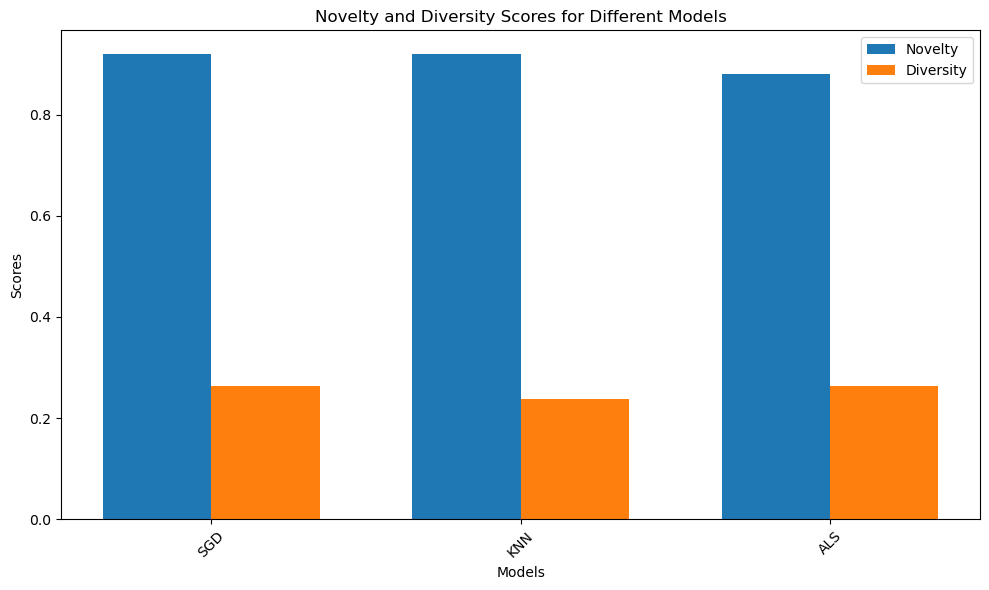

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(models))

bar1 = ax.bar(index, novelty_scores, bar_width, label='Novelty')
bar2 = ax.bar([i + bar_width for i in index], diversity_scores, bar_width, label='Diversity')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Novelty and Diversity Scores for Different Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()